In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation

In [2]:
fpath = '../../resources/lipid-data-species-normalized-pretty.csv'
norm_lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-species-pretty.csv'
lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])

In [3]:
brain_regions = ['DLPFC', 'CN', 'Putamen']

In [4]:
def to_long_format(wide_data):
    s = wide_data.stack(level=1).stack().rename_axis(['Group', 'Species', 'Region', 'Subject'])
    endog = s.to_frame('Level')
    exog = s.index.to_frame()
    exog['Dx'] = [re.sub('^(Control|ChAc).*$', '\\1', s) for s in exog.Subject]
    data = pd.concat([endog, exog], axis=1)
    data = data.astype({
        'Region': CategoricalDtype(categories=brain_regions, ordered=True),
        'Dx': CategoricalDtype(categories=['Control', 'ChAc'], ordered=True),
                       })
    return(data)

data = to_long_format(lipid_species)
normdata = to_long_format(norm_lipid_species)
data

Level Group     Species   Region  \
Group Species    Region  Subject                                          
FC    FC         CN      ChAc 1     74.76526    FC          FC       CN   
                         ChAc 2     62.75982    FC          FC       CN   
                         ChAc 3     85.05140    FC          FC       CN   
                         ChAc 4     85.80184    FC          FC       CN   
                         Control 1  86.01249    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2   0.00024  NSer  NSer 22:6   Putamen   
                         Control 3   0.00074  NSer  NSer 22:6   Putamen   
                         Control 4   0.00008  NSer  NSer 22:6   Putamen   
                         Control 5   0.00034  NSer  NSer 22:6   Putamen   
                         Control 6   0.00042  NSer  NSer 22:6   Putamen   

                                      Subject       Dx  
Group Species    Region  Subject                        
FC    FC         CN      ChAc 1        ChAc 1     ChAc  
                         ChAc 2        ChAc 2     ChAc  
                         ChAc 3        ChAc 3     ChAc  
                         ChAc 4        ChAc 4     ChAc  
                         Control 1  Control 1  Control  
...                                       ...      ...  
NSer  NSer 22:6  Putamen Control 2  Control 2  Control  
                         Control 3  Control 3  Control  
                         Control 4  Control 4  Control  
                         Control 5  Control 5  Control  
                         Control 6  Control 6  Control  

[17790 rows x 6 columns]

## Normalization?  It's necessary.

Here I inspect whether unnormalized data might be amenable for fitting regression models.  The heatmaps show that some lipid species within a lipid group have much higher levels across all or most samples than the rest of the species. Fitting models (later) to unnormalized data confirmed this.

### Lipid group: BMP

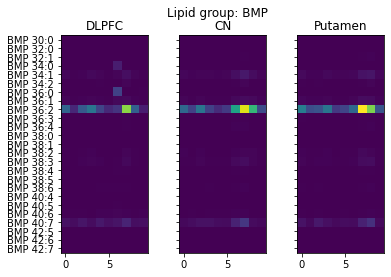

In [5]:
def heatmap(group, data=lipid_species):
    fig, ax = plt.subplots(1, 3, sharey=True)
    for ix, region in enumerate(brain_regions):
        d = data.xs(group, axis=0, level=0)
        vmin = d.min().min()
        vmax = d.max().max()
        d = d.xs(region, axis=1, level=1)
        ax[ix].imshow(d, interpolation='none', vmin=vmin, vmax=vmax)
        ax[ix].set_title(region)
        ax[ix].set_yticks(range(len(d)))
        ax[ix].set_yticklabels(d.index)
        fig.suptitle('Lipid group: ' + group)
    return((fig, ax))    

fig, ax = heatmap('BMP', lipid_species)

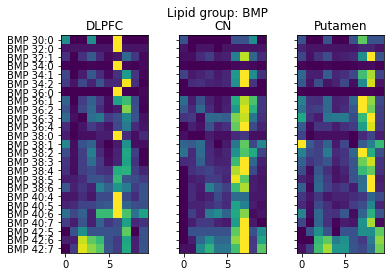

In [6]:
fig, ax = heatmap('BMP', norm_lipid_species)

### Lipid group: Sulf

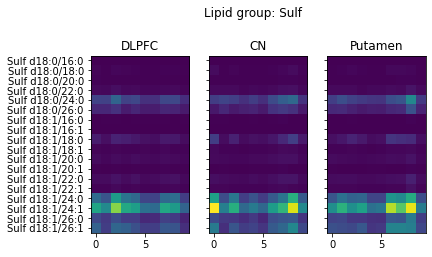

In [7]:
fig, ax = heatmap('Sulf', lipid_species)

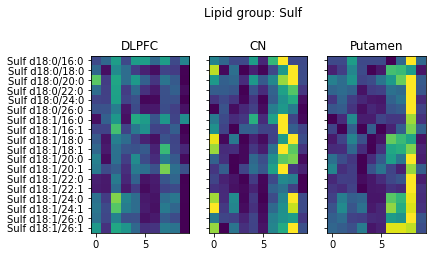

In [8]:
fig, ax = heatmap('Sulf', norm_lipid_species)

### Lipid group: PG

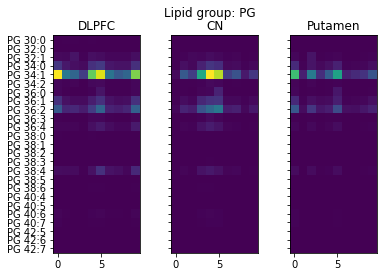

In [9]:
fig, ax = heatmap('PG', lipid_species)

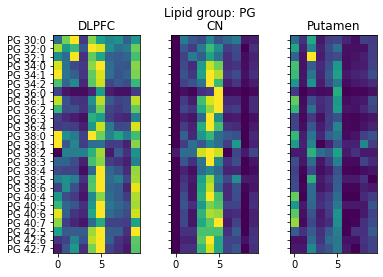

In [10]:
fig, ax = heatmap('PG', norm_lipid_species)

## Goodness of fit

In [11]:
def extract_group(group, df=data):
    val = df.xs(group, axis=0, level='Group')
    return(val)

def fit_to_group(formula, group, effects='mixed', df=normdata):
    d = extract_group(group, df)
    if effects == 'mixed':
        md = smf.mixedlm(formula, data=d, groups='Subject')
    if effects == 'fixed':
        md = smf.ols(formula, data=d)
    mdf = md.fit()
    return(mdf)

### Lipid group: BMP

In [12]:
formulas = ['Level ~ 1 + Dx:Region', 'Level ~ 1 + Dx + Dx:Region', 'Level ~ 1 + Dx + Region + Dx:Region']
sel_groups = ['BMP', 'Sulf', 'PG']
#mixedfs = {f: fit_mixed_to_group(f, 'BMP', df=normdata) for f in formulas}
mixedfs = {g: {f: fit_to_group(f, g, effects='mixed', df=normdata) for f in formulas} for g in sel_groups}
fixedfs = {g: {f: fit_to_group(f, g, effects='fixed', df=normdata) for f in formulas} for g in sel_groups}

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
{g: {f: sms.jarque_bera(m.resid)[1] for f, m in d.items()} for g, d in mixedfs.items()}

{'BMP': {'Level ~ 1 + Dx:Region': 3.994612945889285e-36,
  'Level ~ 1 + Dx + Dx:Region': 3.994612945889113e-36,
  'Level ~ 1 + Dx + Region + Dx:Region': 3.994612945889055e-36},
 'Sulf': {'Level ~ 1 + Dx:Region': 2.213820292935249e-10,
  'Level ~ 1 + Dx + Dx:Region': 2.213820292935381e-10,
  'Level ~ 1 + Dx + Region + Dx:Region': 2.213820292935595e-10},
 'PG': {'Level ~ 1 + Dx:Region': 5.5102796620863075e-14,
  'Level ~ 1 + Dx + Dx:Region': 5.5102796620848724e-14,
  'Level ~ 1 + Dx + Region + Dx:Region': 5.5102796620858026e-14}}

In [15]:
{g: {f: sms.jarque_bera(m.resid)[1] for f, m in d.items()} for g, d in fixedfs.items()}

{'BMP': {'Level ~ 1 + Dx:Region': 5.584233982336527e-35,
  'Level ~ 1 + Dx + Dx:Region': 5.584233982336366e-35,
  'Level ~ 1 + Dx + Region + Dx:Region': 5.584233982336606e-35},
 'Sulf': {'Level ~ 1 + Dx:Region': 3.024415103665322e-12,
  'Level ~ 1 + Dx + Dx:Region': 3.0244151036654002e-12,
  'Level ~ 1 + Dx + Region + Dx:Region': 3.0244151036654673e-12},
 'PG': {'Level ~ 1 + Dx:Region': 4.967621908073297e-13,
  'Level ~ 1 + Dx + Dx:Region': 4.967621908073297e-13,
  'Level ~ 1 + Dx + Region + Dx:Region': 4.967621908074029e-13}}

In [14]:
%connect_info

{
  "shell_port": 58738,
  "iopub_port": 58739,
  "stdin_port": 58740,
  "control_port": 58742,
  "hb_port": 58741,
  "ip": "127.0.0.1",
  "key": "cb655d5b-0723ead18e1739c75c260065",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-92dc17a4-3ede-42d4-8ab8-607ddeecd669.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
